<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "4E"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/4E/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


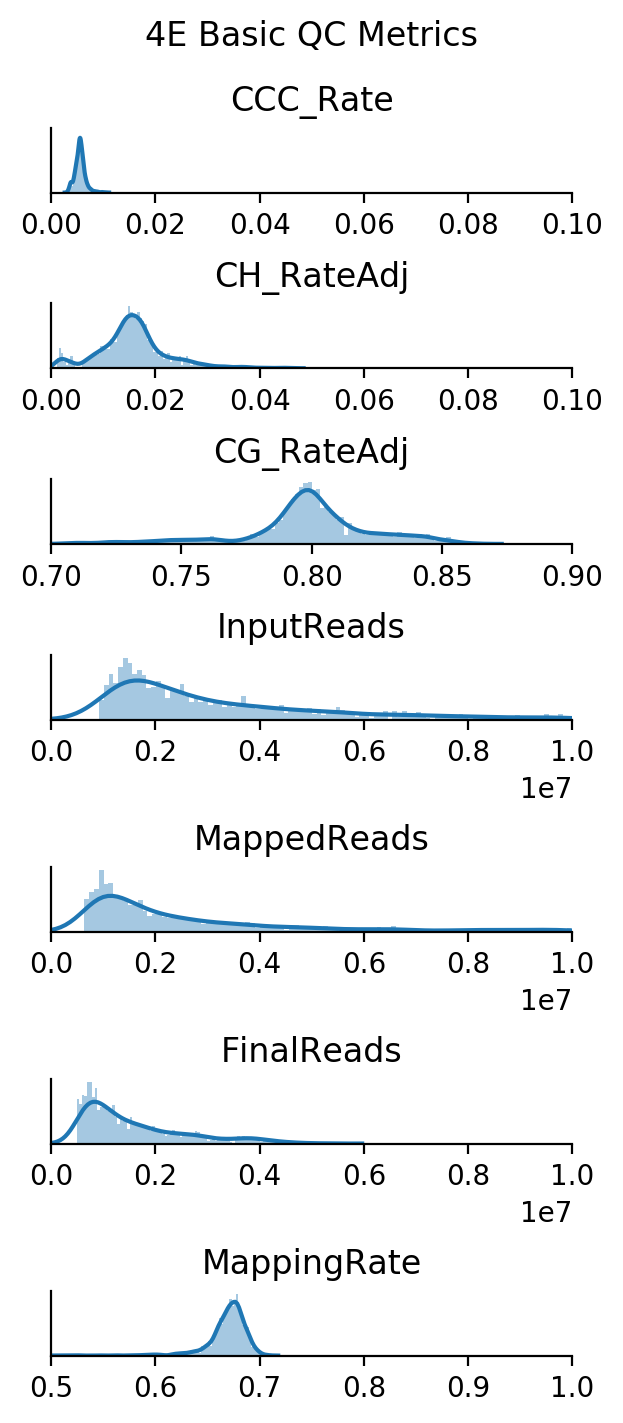

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

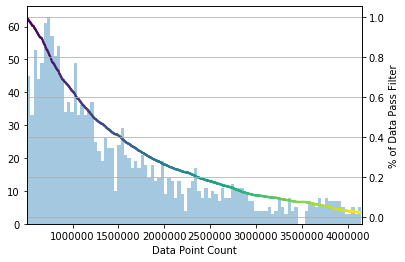

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 1756/1756 (100.0%)
CG_RateAdj passed 1756/1756 (100.0%)
CH_RateAdj passed 1756/1756 (100.0%)
FinalReads passed 1756/1756 (100.0%)
MappingRate passed 1756/1756 (100.0%)
Overall passed 1756/1756 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180110 1218
180111 538


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 208 54.2%
ad002 212 55.2%
ad004 220 57.3%
ad006 229 59.6%
ad007 222 57.8%
ad008 221 57.6%
ad010 223 58.1%
ad012 221 57.6%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
4E_M_0,/gale/raidix/rdx-4/CEMBA_RS1/4E/CEMBA180110_4E...,0.00528,0.80014,0.79908,0.01835,0.01314,1595066.0,3502136,2375830.0,4E,...,6.771184,-7.701653,20.154120,39.819568,MSN-D2 Col14a1,2.140211,-1.323673,-11.094752,-18.771260,True
4E_M_1,/gale/raidix/rdx-4/CEMBA_RS1/4E/CEMBA180110_4E...,0.00553,0.77919,0.77796,0.02325,0.01782,1503661.0,3362688,2263776.0,4E,...,-0.115411,-17.327225,20.386236,-9.311483,D1L-Fstl4 Grm3,12.218011,-6.616120,-21.456851,-11.070108,True
4E_M_10,/gale/raidix/rdx-4/CEMBA_RS1/4E/CEMBA180110_4E...,0.00548,0.78835,0.78718,0.02029,0.01489,2209368.0,5073970,3494807.0,4E,...,1.570417,-17.285257,12.838559,-11.033696,D1L-Fstl4 Trps1,7.480872,-2.670986,1.729263,-11.512470,True
4E_M_100,/gale/raidix/rdx-4/CEMBA_RS1/4E/CEMBA180110_4E...,0.00379,0.66450,0.66322,0.00653,0.00275,2059589.0,5383970,3621426.0,4E,...,7.436868,11.092522,-66.546642,-7.790594,PC pc-all,1.065612,7.330867,0.725275,-0.586106,True
4E_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/4E/CEMBA180110_4E...,0.00550,0.79441,0.79327,0.02155,0.01614,1130491.0,2318168,1522045.0,4E,...,-0.246009,-17.199350,18.251301,-7.608285,D1L-Fstl4 Grm3,11.410252,-5.523188,-15.409254,-10.025628,True
4E_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/4E/CEMBA180110_4E...,0.00485,0.79962,0.79864,0.01420,0.00940,1016901.0,2054628,1381103.0,4E,...,5.758811,-15.468109,27.831313,-28.561105,D1L-PAL Flrt2,6.001932,-7.078254,3.151719,-9.318664,True
4E_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/4E/CEMBA180110_4E...,0.00492,0.80577,0.80481,0.01518,0.01031,1156544.0,2329542,1577001.0,4E,...,1.522022,-0.215053,-26.993516,37.903653,Foxp2 Dchs2,3.575424,-6.501519,-17.907521,1.165547,True
4E_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/4E/CEMBA180110_4E...,0.00582,0.80136,0.80020,0.02135,0.01562,1118349.0,2255174,1527774.0,4E,...,-2.017073,-18.891356,41.868782,-2.137010,MSN-D1 Plxnc1,-6.044587,-0.187457,-4.225949,19.277113,True
4E_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/4E/CEMBA180110_4E...,0.00536,0.81274,0.81173,0.01995,0.01467,1029125.0,2188828,1436507.0,4E,...,2.383047,-1.644649,-15.909709,42.600987,Foxp2 Dchs2,-3.118718,-3.207709,-3.619301,-19.570791,True
4E_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/4E/CEMBA180110_4E...,0.00563,0.81775,0.81672,0.01863,0.01307,774664.0,1650044,1090518.0,4E,...,-0.429942,1.024962,-36.428259,29.742261,Foxp2 Inpp4b,-0.736092,-10.465874,-11.765060,23.323470,True
